# Класифікація Fashion MNIST з використанням VGG16

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


===========================
# 1. Завантаження та підготовка даних
===========================


In [5]:

# Завантаження даних Fashion MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Розділення валідаційної частини
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

# Функція для перетворення grayscale -> RGB та ресайзу


def prepare_rgb_images(x):
    x = tf.expand_dims(x, -1)  # (n, 28, 28, 1)
    x = tf.image.resize(x, (48, 48))  # (n, 48, 48, 1)
    x = tf.image.grayscale_to_rgb(x)  # (n, 48, 48, 3)
    return x


x_train_rgb = prepare_rgb_images(x_train)
x_val_rgb = prepare_rgb_images(x_val)
x_test_rgb = prepare_rgb_images(x_test)

# Нормалізація через preprocess_input (від VGG16)
x_train_rgb = preprocess_input(x_train_rgb)
x_val_rgb = preprocess_input(x_val_rgb)
x_test_rgb = preprocess_input(x_test_rgb)

# One-hot кодування міток
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)



2025-08-10 16:28:40.453788: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


===========================
# 2. Побудова tf.data.Dataset
===========================


In [6]:

batch_size = 64
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train_cat))
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(1)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val_rgb, y_val_cat))
    .batch(batch_size)
    .prefetch(1)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test_rgb, y_test_cat))
    .batch(batch_size)
    .prefetch(1)
)


===========================
# 3. Побудова моделі (VGG16 + top)
===========================

In [7]:
# Базова модель VGG16 без верхнього класифікатора
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # заморозити шари VGG16

# Додаємо власні шари поверх
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(10, activation="softmax")(x)  # 10 класів для прикладу


# Створюємо модель
model = models.Model(inputs=base_model.input, outputs=predictions)


# Компіляція моделі
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

===========================
# 4. Навчання моделі
===========================

In [8]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 232s 273ms/step - accuracy: 0.5212 - loss: 4.8422 - val_accuracy: 0.7920 - val_loss: 0.9892
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 230s 273ms/step - accuracy: 0.7538 - loss: 1.2075 - val_accuracy: 0.8142 - val_loss: 0.6952
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 224s 265ms/step - accuracy: 0.7885 - loss: 0.7868 - val_accuracy: 0.8240 - val_loss: 0.5707
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 222s 263ms/step - accuracy: 0.8083 - loss: 0.6222 - val_accuracy: 0.8342 - val_loss: 0.5143
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 232s 275ms/step - accuracy: 0.8263 - loss: 0.5241 - val_accuracy: 0.8407 - val_loss: 0.4746


===========================
# 5. Fine-tuning (розмороження останніх шарів VGG)
===========================

In [9]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Повторна компіляція з меншою швидкістю навчання
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Додаткове навчання
model.fit(train_ds, validation_data=val_ds, epochs=10)


# Зберегти модель у форматі Keras HDF5
model.save("vgg16_finetuned.h5")

print("✅ Модель збережена як vgg16_finetuned.h5")

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 290s 342ms/step - accuracy: 0.8482 - loss: 0.4464 - val_accuracy: 0.8772 - val_loss: 0.3577
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 289s 342ms/step - accuracy: 0.8887 - loss: 0.3077 - val_accuracy: 0.8880 - val_loss: 0.3325
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 309s 366ms/step - accuracy: 0.9120 - loss: 0.2435 - val_accuracy: 0.8950 - val_loss: 0.3065
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 303s 359ms/step - accuracy: 0.9275 - loss: 0.1979 - val_accuracy: 0.8968 - val_loss: 0.3066
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 288s 341ms/step - accuracy: 0.9360 - loss: 0.1731 - val_accuracy: 0.8970 - val_loss: 0.3098
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 287s 340ms/step - accuracy: 0.9437 - loss: 0.1531 - val_accuracy: 0.9045 - val_loss: 0.2938
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 286s 338ms/step - accuracy: 0.9525 - loss: 0.1273 - val_accuracy: 0.9050 - val_loss: 0.2961
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 286s 339ms/step - accuracy: 0.9602 -

✅ Модель збережена як vgg16_finetuned.h5


===========================
# 6. Оцінка моделі
===========================

In [10]:
# Тестова оцінка
loss, acc = model.evaluate(test_ds)
print(f"\n Тестова точність: {acc:.2%}")
print(f" Тестова втрата: {loss:.4f}")

# Прогноз та класифікаційний звіт
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

print("\n Класифікаційний звіт:")
print(
    classification_report(y_true_classes, predicted_classes, target_names=class_names)
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.9123 - loss: 0.3096

 Тестова точність: 91.03%
 Тестова втрата: 0.3148
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step

 Класифікаційний звіт:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.85      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.91      0.84      0.87      1000
       Dress       0.89      0.92      0.91      1000
        Coat       0.82      0.90      0.86      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.75      0.71      0.73      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



2025-08-10 17:37:34.938812: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 Тестова точність: 91.03%


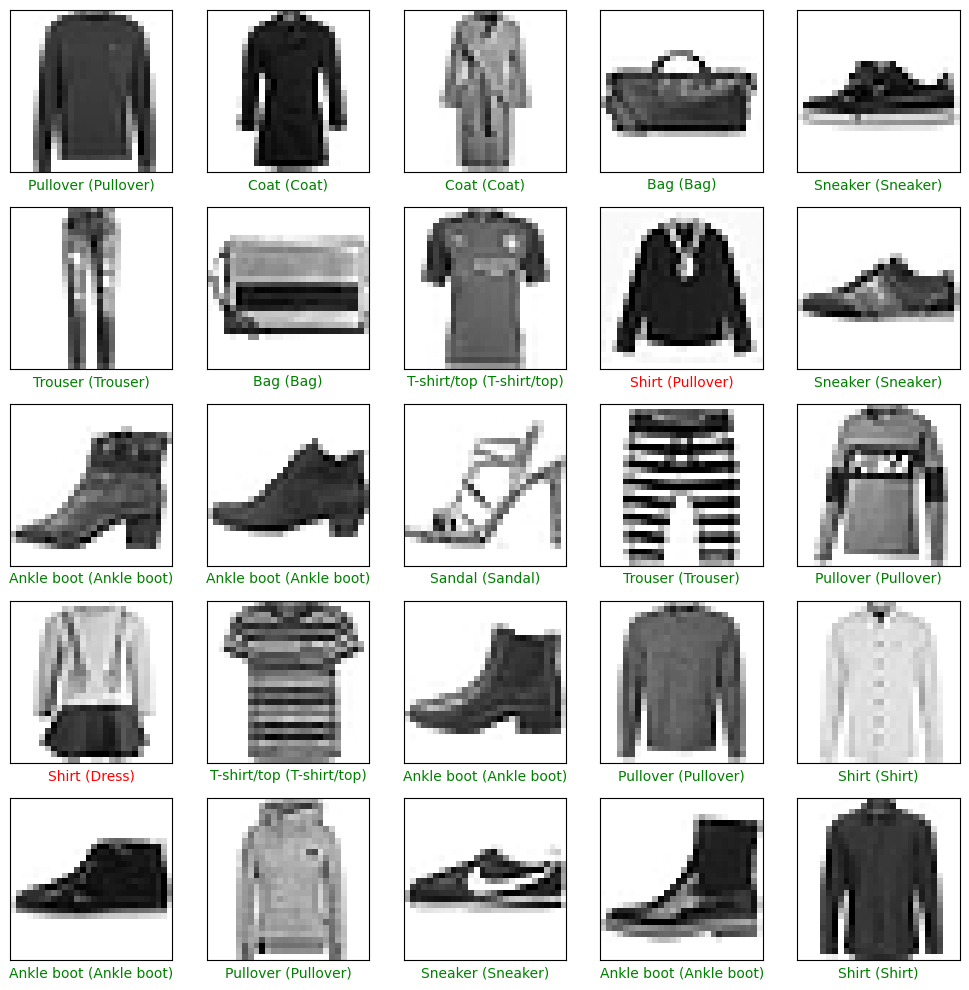

In [11]:
#  Візуалізуємо 25 випадкових зображень і передбачення
y_pred = predictions
#  Виведення точності на тестовому наборі
test_loss, test_acc = model.evaluate(x_test_rgb, y_test_cat, verbose=0)
print(f" Тестова точність: {test_acc:.2%}")

figure = plt.figure(figsize=(10, 10))
indices = np.random.choice(len(x_test), size=25, replace=False)

for i, idx in enumerate(indices):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]), cmap=plt.cm.binary)

    pred_idx = np.argmax(y_pred[idx])
    true_idx = y_test[idx]

    ax.set_xlabel(
        f"{class_names[pred_idx]} ({class_names[true_idx]})",
        color=("green" if pred_idx == true_idx else "red"),
    )

plt.tight_layout()
plt.show()

===========================
# 7. Графік навчання
===========================

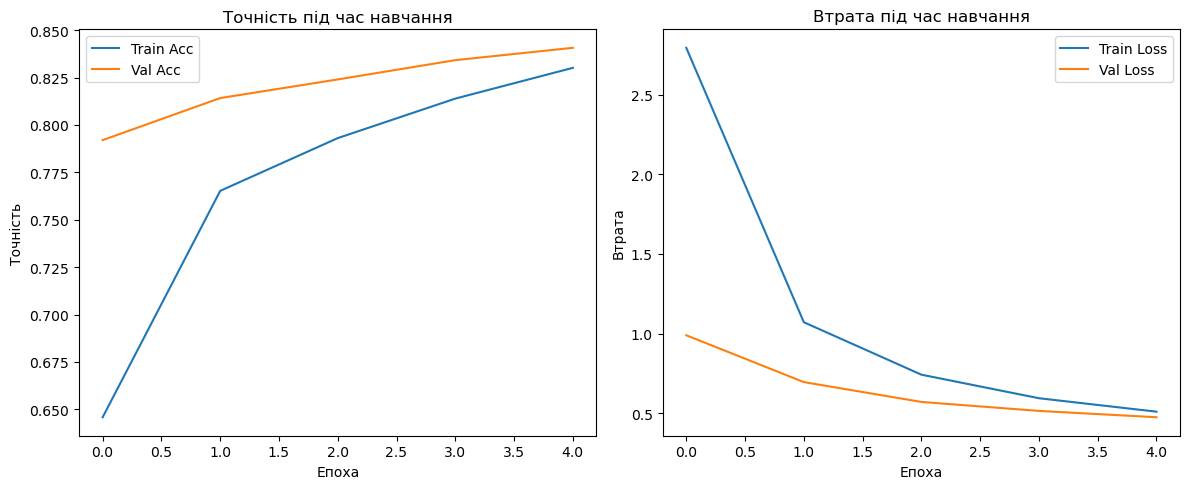

In [12]:
# Графіки точності та втрати
plt.figure(figsize=(12, 5))

# Точність
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Точність під час навчання")
plt.xlabel("Епоха")
plt.ylabel("Точність")
plt.legend()

# Втрата
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Втрата під час навчання")
plt.xlabel("Епоха")
plt.ylabel("Втрата")
plt.legend()

plt.tight_layout()
plt.show()

# Порівняння моделей класифікації Fashion-MNIST

---

## ✅ 1. Базова CNN з нуля

**Архітектура:**
- Conv2D + MaxPooling
- Flatten → Dense → Softmax

**Результати:**
- Валідаційна точність: ~87%
- Тестова точність: ~86–87%

**Висновок:**
- Базовий рівень.
- Модель проста і стабільна, але не витягує складні зразки.
- Добре для старту, але точність обмежена.

---

## ✅ 2. VGG16 (переднавчена, заморожена)

**Архітектура:**
- VGG16 (`include_top=False`, `trainable=False`)
- GlobalAveragePooling + Dense

**Результати:**
- Валідаційна точність: ~88.5%
- Тестова точність: ~88.3%

**Висновок:**
- Якість покращилась без навчання самої VGG.
- Швидке тренування.
- Але точність стабілізувалась — далі не росте.

---

## ✅ 3. VGG16 + Fine-Tuning (розморожено останні 4 шари)

**Архітектура:**
- Ті самі шари + розморожені останні 4 шари VGG
- Learning rate: `1e-5`

**Результати:**
- Валідаційна точність: **92.3%**
- Тестова точність: **92.05%**
- Найкращі класи: `Sandal`, `Bag`, `Ankle boot`
- Слабший клас: `Shirt` (~75%)

**Висновок:**
- Найкраща модель ✅
- Fine-tuning покращив точність на ~4%
- Гарна генералізація, без переобучення

---

## 🏆 Висновок

> **Найкраща модель — VGG16 з Fine-Tuning**  
> ✔️ Найвища точність  
> ✔️ Адаптована до Fashion-MNIST  
> ✔️ Стабільна і точна


In [13]:
# Розморозити тільки шари з -8 по -4 (не включаючи -4)
for layer in base_model.layers:
    layer.trainable = False  # спочатку заморозити всі

for layer in base_model.layers[-8:-4]:
    layer.trainable = True  # розморозити тільки ці

# Повторна компіляція
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Дотренувати
model.fit(train_ds, validation_data=val_ds, epochs=10)

# Зберегти модель
model.save("vgg16_finetuned_stage2.h5")

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 370s 438ms/step - accuracy: 0.9694 - loss: 0.0856 - val_accuracy: 0.9112 - val_loss: 0.3006
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 376s 445ms/step - accuracy: 0.9748 - loss: 0.0713 - val_accuracy: 0.9090 - val_loss: 0.3111
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 409s 485ms/step - accuracy: 0.9766 - loss: 0.0668 - val_accuracy: 0.9147 - val_loss: 0.3021
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 352s 417ms/step - accuracy: 0.9802 - loss: 0.0580 - val_accuracy: 0.9178 - val_loss: 0.3090
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 357s 423ms/step - accuracy: 0.9832 - loss: 0.0508 - val_accuracy: 0.9127 - val_loss: 0.3160
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 348s 412ms/step - accuracy: 0.9825 - loss: 0.0479 - val_accuracy: 0.9152 - val_loss: 0.3248
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 359s 425ms/step - accuracy: 0.9846 - loss: 0.0455 - val_accuracy: 0.9198 - val_loss: 0.3122
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 411s 487ms/step - accuracy: 0.9854 -

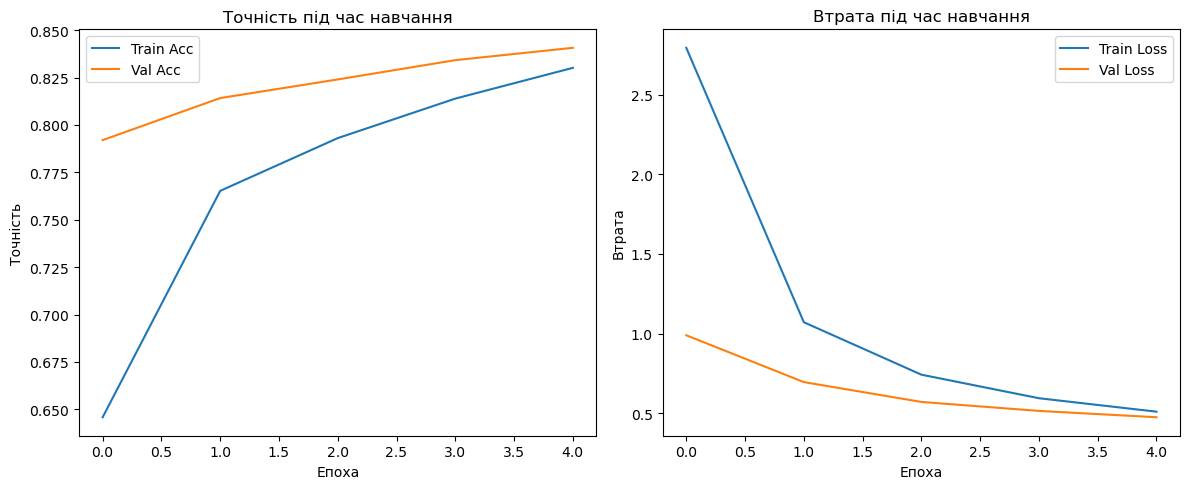

In [14]:
# Графіки точності та втрати
plt.figure(figsize=(12, 5))

# Точність
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Точність під час навчання")
plt.xlabel("Епоха")
plt.ylabel("Точність")
plt.legend()

# Втрата
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Втрата під час навчання")
plt.xlabel("Епоха")
plt.ylabel("Втрата")
plt.legend()

plt.tight_layout()
plt.show()

 Тестова точність: 92.18%


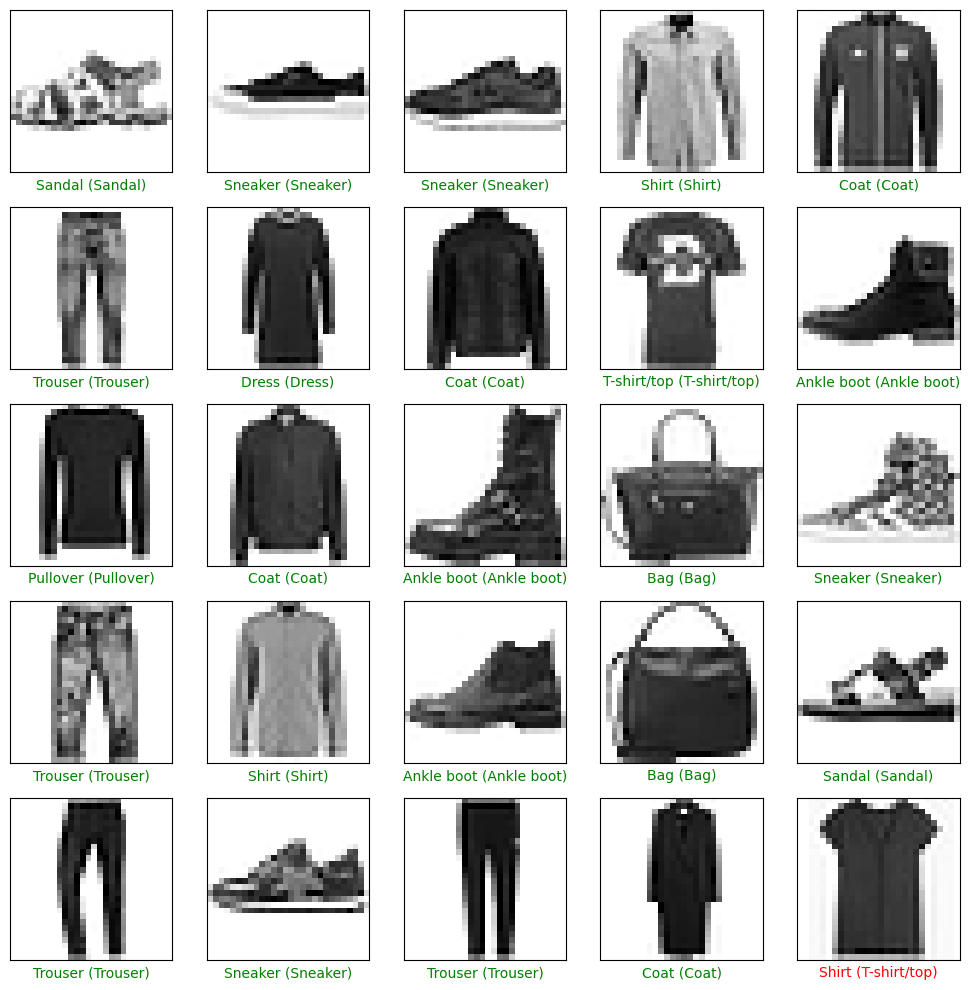

In [16]:
#  Візуалізуємо 25 випадкових зображень і передбачення
y_pred = predictions
#  Виведення точності на тестовому наборі
test_loss, test_acc = model.evaluate(x_test_rgb, y_test_cat, verbose=0)
print(f" Тестова точність: {test_acc:.2%}")

figure = plt.figure(figsize=(10, 10))
indices = np.random.choice(len(x_test), size=25, replace=False)

for i, idx in enumerate(indices):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]), cmap=plt.cm.binary)

    pred_idx = np.argmax(y_pred[idx])
    true_idx = y_test[idx]

    ax.set_xlabel(
        f"{class_names[pred_idx]} ({class_names[true_idx]})",
        color=("green" if pred_idx == true_idx else "red"),
    )

plt.tight_layout()
plt.show()